# Training Model for Quora Question Pairs's Training Dataset:

In [1]:
# avoid decoding problems
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
df = pd.read_csv("train.csv")
 
# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))

In [2]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


- It is a better choice to go further with TF-IDF scoring. 
- For TF-IDF, I used scikit-learn (heaven of ML).  
- It provides TfIdfVectorizer which does everything you need.
- here we use a pre-trained GLOVE model which comes free with "Spacy". 
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores. - The below code does this for "question1" and "question2" columns.
- This is how we use Spacy for this purpose.

In [4]:
# exctract word2vec vectors
import spacy

nlp = spacy.load('en')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), 300])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [08:38<00:00, 779.85it/s]


In [5]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 300])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [08:41<00:00, 775.49it/s]


- Reading the Features (Explored in EDA) like : preprocessing features and NLP features

In [6]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
dfnlp = pd.read_csv("df_nlp_features.csv")
dfppro = pd.read_csv("df_preprocessing_features.csv")
dfppro.shape
#dfnlp.shape

(404290, 11)

In [7]:
dfnlp.shape

(404290, 15)

In [8]:
dfppro.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [9]:
dfnlp.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.0,86,63,66,75,0
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0


In [10]:
#all_feats = np.concatenate()

#frames = [df, dfppro, dfnlp]

df_all_features = pd.concat([dfppro, dfnlp], axis=1)
df_all_features.shape

(404290, 26)

In [11]:
df_all_features.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,...,0.466664,0.0,1.0,5.0,12.0,86,63,66,75,0
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0


In [12]:
#W2V Question1 Vector
Q1_vec = df['q1_feats_m'].values
#W2V Question2 Vector
Q2_vec = df['q2_feats_m'].values
#Features Extracted in EDA
feat_26 = df_all_features.values

In [13]:
a = [1,2,3]
b = [2,3,4]
c = [3,4]
np.concatenate((a,b,c))

array([1, 2, 3, 2, 3, 4, 3, 4])

- Creating a Single vector with the combination of all 2 W2V vectors and all Features(26)
- "features"  : is the combined vectorof length 626 of all 3 thinngs

In [14]:
features = []
for i in range(0,len(Q1_vec)):
    Q1 = Q1_vec[i]
    Q2 = Q2_vec[i]
    f = feat_26[i]
    features.append(np.concatenate((Q1,Q2,f)))

In [15]:
features = np.array(features)
print len(features[0])
#print Q1_vec[0][0:15]
#print Q2_vec[0][0:15]
#print feat_26[0]
print len(features)

626
404290


- "lbl" = Lables Values or class 

In [18]:
lbl = df["is_duplicate"].values

- Splitting the train and test data into 80% and 20%

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


#test_proportion of 3 means 1/3 so 33% test and 67% train
def shuffle(matrix, target, test_proportion):
    ratio = matrix.shape[0]/test_proportion
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:]
    Y_test =  target[:ratio]
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = shuffle(features, lbl, 5)

/home/darshan_excellence/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


-Implementing Logistic Regression:

In [21]:
#logistic regression

best_params_logreg = []
parameters = {'loss':['log'],'penalty':['l1','l2','elasticnet'],'alpha':[0.001,0.01,0.1,1,10,20,30,40,50,60,70,80,90,100], 'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf,parameters,cv = 5)
clf.fit(X_train,Y_train)
best_params_logreg.append(clf.best_params_)
print best_params_logreg

[{'penalty': 'elasticnet', 'alpha': 0.1, 'n_jobs': -1, 'loss': 'log'}]


In [22]:
#Do a test with cross validation
clf = SGDClassifier(loss= 'log',penalty = 'l2',alpha = 0.1,n_jobs = -1)
#choose best parameters
score = cross_val_score(clf,X_train,Y_train,cv = 5)

In [23]:
#cross validation score. Test it
print sum(score)/len(score)

0.778148102907


In [24]:
#test set Prediction
from sklearn.metrics import confusion_matrix
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
conf_log_ref = confusion_matrix(Y_test,Y_pred)

In [25]:
#confusion matrix
print conf_log_ref

[[44737  5970]
 [11710 18441]]


In [26]:
true = conf_log_ref[0][0]+conf_log_ref[1][1]
false = conf_log_ref[0][1]+conf_log_ref[1][0]
print "Test accuracy:",float(true)*100/(true+false)

Test accuracy: 78.134507408


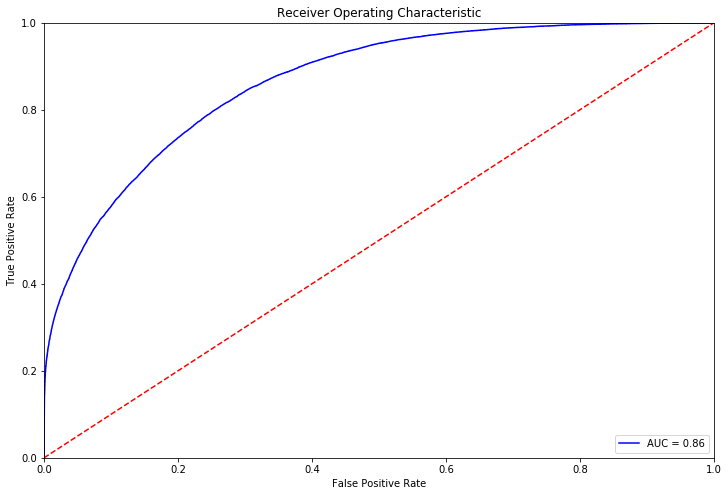

Precision : 75.5438122158
Recall : 61.1621505091


In [27]:
score_Log_reg = []

#ROC for a given alpha for log reg
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()





#Precision and recall
tn = conf_log_ref[0,0]; fp = conf_log_ref[0,1]; fn = conf_log_ref[1,0]; tp = conf_log_ref[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print "Precision :",precision
print "Recall :",recall


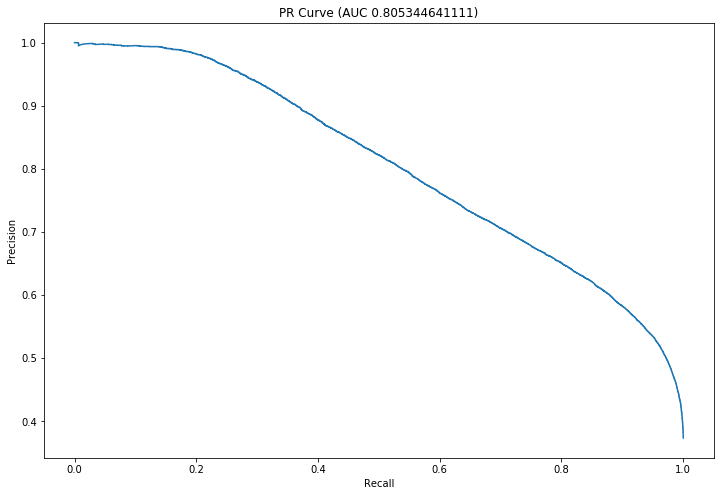

In [28]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve
pr, re, _ = precision_recall_curve(Y_test, clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

- Using SVD:

In [47]:
#SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

svd = TruncatedSVD(n_components=300)
xtrain_svd = svd.fit_transform(X_train)
xtest_svd = svd.transform(X_test)

In [48]:
#logistic regression with SVD

best_params_logreg = []
parameters = {'loss':['log'],'penalty':['l1','l2','elasticnet'],'alpha':[0.001,0.01,0.1,1,10,20,30,40,50,60,70,80,90,100], 'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf,parameters,cv = 5)
clf.fit(xtrain_svd,Y_train)
best_params_logreg.append(clf.best_params_)
print best_params_logreg

[{'penalty': 'l2', 'alpha': 0.1, 'n_jobs': -1, 'loss': 'log'}]


In [31]:
#Do a test with cross validation
clf = SGDClassifier(loss= 'log',penalty = 'l2',alpha = 1,n_jobs = -1)
#choose best parameters
score = cross_val_score(clf,xtrain_svd,Y_train,cv = 5)

In [32]:
#cross validation score.
print sum(score)/len(score)

0.728038679213


In [33]:
#test set
from sklearn.metrics import confusion_matrix
clf.fit(xtrain_svd,Y_train)
Y_pred = clf.predict(xtest_svd)
conf_log_ref = confusion_matrix(Y_test,Y_pred)

In [34]:
#confusion matrix
print conf_log_ref

[[42358  8349]
 [13136 17015]]


In [35]:
true = conf_log_ref[0][0]+conf_log_ref[1][1]
false = conf_log_ref[0][1]+conf_log_ref[1][0]
print "Test accuracy with SVD:",float(true)*100/(true+false)

Test accuracy with SVD: 73.428726904


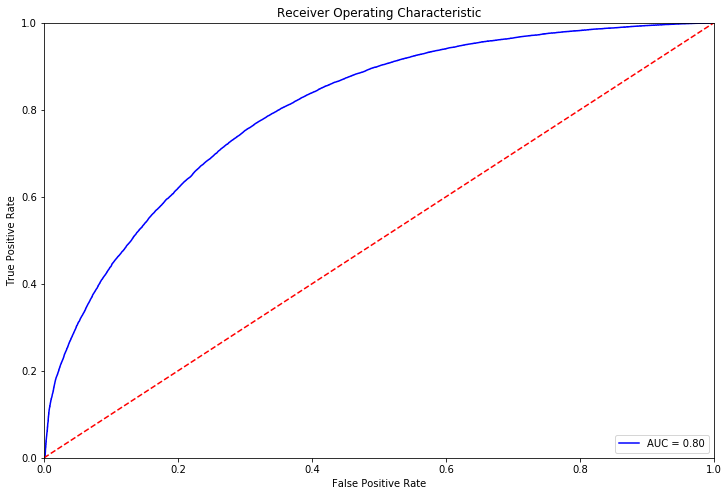

Precision : 67.0832676234
Recall : 56.4326224669


In [36]:

score_Log_reg = []

#ROC for a given alpha for log reg
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(xtest_svd)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()





#Precision and recall
tn = conf_log_ref[0,0]; fp = conf_log_ref[0,1]; fn = conf_log_ref[1,0]; tp = conf_log_ref[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print "Precision :",precision
print "Recall :",recall




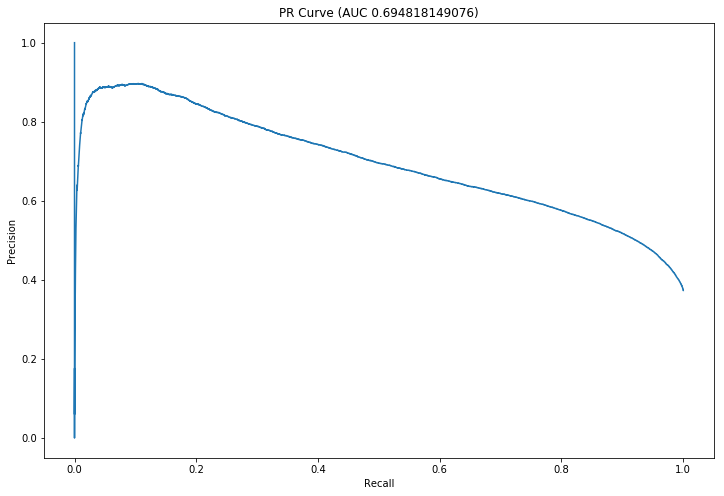

In [37]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve
pr, re, _ = precision_recall_curve(Y_test, clf.predict_proba(xtest_svd)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using XG-Boost for better result:

In [39]:
#XG-Boost
import xgboost as xgb

In [40]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=Y_train)
d_valid = xgb.DMatrix(X_test, label=Y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)



xgdmat = xgb.DMatrix(X_train, Y_train) # Create our DMatrix to make XGBoost more efficient
#Now let’s specify our parameters

[0]	train-logloss:0.684874	valid-logloss:0.68485
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61497	valid-logloss:0.614961
[20]	train-logloss:0.564574	valid-logloss:0.564663
[30]	train-logloss:0.526446	valid-logloss:0.526749
[40]	train-logloss:0.497318	valid-logloss:0.497832
[50]	train-logloss:0.474221	valid-logloss:0.474874
[60]	train-logloss:0.455786	valid-logloss:0.456649
[70]	train-logloss:0.441134	valid-logloss:0.442104
[80]	train-logloss:0.429209	valid-logloss:0.430262
[90]	train-logloss:0.419703	valid-logloss:0.4208
[100]	train-logloss:0.411767	valid-logloss:0.412922
[110]	train-logloss:0.405076	valid-logloss:0.406258
[120]	train-logloss:0.399539	valid-logloss:0.400765
[130]	train-logloss:0.394769	valid-logloss:0.396019
[140]	train-logloss:0.390956	valid-logloss:0.392238
[150]	train-logloss:0.387527	valid-logloss:0.388846
[160]	train-logloss:0.384669	val

In [41]:
print round(0.6)
print round(0.5)
print round(0.4)

1.0
1.0
0.0


In [42]:
d_test = xgb.DMatrix(X_test)
Y_pred = bst.predict(d_test)

In [43]:

print Y_pred
for i in range(0,len(Y_pred)):
    if Y_pred[i]>=0.5:
        Y_pred[i]=1
    else:
        Y_pred[i]=0
        

[ 0.40809453  0.28530639  0.12771755 ...,  0.71649224  0.86554301
  0.00338006]


In [44]:
conf_xgb = confusion_matrix(Y_test,Y_pred)
print conf_xgb

[[45598  5109]
 [ 9274 20877]]


In [45]:
true = conf_xgb[0][0]+conf_xgb[1][1]
false = conf_xgb[0][1]+conf_xgb[1][0]
print "Test accuracy with X-Gboost:",float(true)*100/(true+false)

Test accuracy with X-Gboost: 82.2120260209


In [46]:


#Precision and recall
tn = conf_xgb[0,0]; fp = conf_xgb[0,1]; fn = conf_xgb[1,0]; tp = conf_xgb[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print "Precision :",precision
print "Recall :",recall




Precision : 80.3394135304
Recall : 69.2414845279


In [49]:
df_test = pd.read_csv("test.csv")

In [50]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [ ]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)